# EDA — Estadística UTI Quirúrgica y Neuroquirúrgica (2024-2025)

Análisis exploratorio de datos de pacientes que transitaron por ambas unidades de cuidados intensivos.  
**Datos anonimizados** — se eliminan nombre, RUT, ficha y código desde la carga.

---

## 0 — Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
import warnings, re, unicodedata
warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid', palette='Set2', font_scale=1.1)
pd.set_option('display.max_columns', 30)

# Columnas a eliminar para anonimizar
DROP_COLS = ['NOMBRE', 'RUT', 'ficha', 'c\u00f3digo', 'código', 'codigo',
             'Unnamed: 0', '#']

print('Setup OK')

Setup OK


## 1 — Carga y anonimización

In [2]:
def load_and_clean(path, uti_label):
    """Carga Hoja1, anonimiza, filtra >=2024 y normaliza columnas."""
    df = pd.read_excel(path, sheet_name=0)
    
    # --- Anonimizar: eliminar columnas identificatorias ---
    cols_to_drop = [c for c in df.columns if c in DROP_COLS 
                    or c.upper() in [x.upper() for x in DROP_COLS]]
    df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
    
    # Eliminar '# mes' (correlativo interno, no aporta al análisis)
    df.drop(columns=['# mes'], inplace=True, errors='ignore')
    
    # --- Normalizar nombres de columnas ---
    rename = {
        'ingreso': 'INGRESO', 'egreso': 'EGRESO',
        'DÍAS ESTADÍA': 'DIAS_ESTADIA',
        'D\u00cdAS ESTAD\u00cdA': 'DIAS_ESTADIA',
        'SCORE APACHE II': 'APACHE_II',
        'DIAGNÓSTICO': 'DIAGNOSTICO',
        'DIAGN\u00d3STICO': 'DIAGNOSTICO',
        'CONDICIÓN AL EGRESO': 'CONDICION_EGRESO',
        'CONDICI\u00d3N AL EGRESO': 'CONDICION_EGRESO',
        'GÉNERO': 'GENERO',
        'G\u00c9NERO': 'GENERO',
    }
    df.rename(columns={k: v for k, v in rename.items() if k in df.columns}, inplace=True)
    
    # Forzar encoding para columnas con problemas
    col_map = {}
    for c in df.columns:
        clean = c
        if 'ESTAD' in c.upper():
            clean = 'DIAS_ESTADIA'
        elif 'APACHE' in c.upper():
            clean = 'APACHE_II'
        elif 'DIAGN' in c.upper():
            clean = 'DIAGNOSTICO'
        elif 'CONDICI' in c.upper():
            clean = 'CONDICION_EGRESO'
        elif 'NERO' in c.upper() and 'G' in c.upper():
            clean = 'GENERO'
        elif c.lower() == 'ingreso':
            clean = 'INGRESO'
        elif c.lower() == 'egreso':
            clean = 'EGRESO'
        col_map[c] = clean
    df.rename(columns=col_map, inplace=True)
    
    # --- Convertir fechas ---
    df['INGRESO'] = pd.to_datetime(df['INGRESO'], errors='coerce')
    df['EGRESO'] = pd.to_datetime(df['EGRESO'], errors='coerce')
    
    # --- Filtrar: solo 2024 en adelante ---
    df = df[df['INGRESO'].dt.year >= 2024].copy()
    
    # --- Limpiar filas completamente vacías ---
    df = df.dropna(how='all').copy()
    # Eliminar filas sin datos esenciales (sin ingreso Y sin edad)
    df = df.dropna(subset=['INGRESO', 'EDAD'], how='all').copy()
    
    # --- Convertir numéricas ---
    df['DIAS_ESTADIA'] = pd.to_numeric(df['DIAS_ESTADIA'], errors='coerce')
    df['APACHE_II'] = pd.to_numeric(df['APACHE_II'], errors='coerce')
    df['EDAD'] = pd.to_numeric(df['EDAD'], errors='coerce')
    
    # --- Etiquetar UTI ---
    df['UTI'] = uti_label
    
    df.reset_index(drop=True, inplace=True)
    return df

df_nqx = load_and_clean('../data/estadistica/ESTADISTICA UTI NEUROQUIRURGICA 2025.xlsx', 'UTINQX')
df_qx = load_and_clean('../data/estadistica/ESTADISTICA UTI QUIRURGICA 2025.xlsx', 'UTIQX')

print(f'UTINQX: {df_nqx.shape}')
print(f'UTIQX:  {df_qx.shape}')
print(f'\nColumnas UTINQX: {list(df_nqx.columns)}')
print(f'Columnas UTIQX:  {list(df_qx.columns)}')

UTINQX: (673, 11)
UTIQX:  (1362, 11)

Columnas UTINQX: ['EDAD', 'GENERO', 'INGRESO', 'EGRESO', 'DIAS_ESTADIA', 'APACHE_II', 'DIAGNOSTICO', 'CONDICION_EGRESO', 'PROCEDENCIA', 'DESTINO', 'UTI']
Columnas UTIQX:  ['EDAD', 'GENERO', 'INGRESO', 'EGRESO', 'DIAS_ESTADIA', 'APACHE_II', 'DIAGNOSTICO', 'CONDICION_EGRESO', 'PROCEDENCIA', 'DESTINO', 'UTI']


In [3]:
# Unificar en un solo DataFrame
# Asegurar mismas columnas
common_cols = ['EDAD', 'GENERO', 'INGRESO', 'EGRESO', 'DIAS_ESTADIA',
               'APACHE_II', 'DIAGNOSTICO', 'CONDICION_EGRESO',
               'PROCEDENCIA', 'DESTINO', 'UTI']

df = pd.concat([df_nqx[common_cols], df_qx[common_cols]], ignore_index=True)
print(f'Dataset combinado: {df.shape}')
df.head()

Dataset combinado: (2035, 11)


,EDAD,GENERO,INGRESO,EGRESO,DIAS_ESTADIA,APACHE_II,DIAGNOSTICO,CONDICION_EGRESO,PROCEDENCIA,DESTINO,UTI
0,37.0,FEMENINO,2024-01-03,2024-01-04,1.0,8.0,EPEDIMOMA INTRAMODULAR,VIVO,NCX,SALA,UTINQX
1,47.0,FEMENINO,2024-01-04,2024-01-31,27.0,14.0,"TUMOR MALIGNO DEL CEREBRO, EXCEPTO LOBULOS",VIVO,UTI Q,NCX,UTINQX
2,58.0,FEMENINO,2024-01-09,2024-01-17,8.0,9.0,TRAUMATISMO INTERNO INTESTINO DELGADO,VIVO,UTI Q,SALA,UTINQX
3,17.0,MASCULINO,2024-01-11,2024-01-31,20.0,11.0,LESION MEDULAR CERVICAL,VIVO,UCI Q,SALA,UTINQX
4,73.0,MASCULINO,2024-01-14,2024-02-06,23.0,14.0,ADENOCARCINOMA LOCALIZADO EN EL 2° DUODENO,VIVO,UTI Q,CX,UTINQX


## 2 — Comprensión de la estructura

In [4]:
print('=== DIMENSIONES ===')
print(f'Total: {df.shape[0]} registros, {df.shape[1]} columnas')
for uti in ['UTINQX', 'UTIQX']:
    n = df[df.UTI == uti].shape[0]
    print(f'  {uti}: {n} registros')

print('\n=== TIPOS DE DATOS ===')
print(df.dtypes)

print('\n=== RANGO TEMPORAL ===')
for uti in ['UTINQX', 'UTIQX']:
    sub = df[df.UTI == uti]
    print(f'  {uti}: {sub.INGRESO.min().date()} a {sub.INGRESO.max().date()}')

=== DIMENSIONES ===
Total: 2035 registros, 11 columnas
  UTINQX: 673 registros
  UTIQX: 1362 registros

=== TIPOS DE DATOS ===
EDAD                       float64
GENERO                         str
INGRESO             datetime64[us]
EGRESO              datetime64[us]
DIAS_ESTADIA               float64
APACHE_II                  float64
DIAGNOSTICO                    str
CONDICION_EGRESO               str
PROCEDENCIA                    str
DESTINO                        str
UTI                            str
dtype: object

=== RANGO TEMPORAL ===
  UTINQX: 2024-01-03 a 2025-12-31
  UTIQX: 2024-01-02 a 2025-12-31


In [5]:
# Valores nulos por columna y UTI
null_summary = df.groupby('UTI').apply(lambda x: x.isnull().sum()).T
null_pct = df.groupby('UTI').apply(lambda x: (x.isnull().sum() / len(x) * 100).round(1)).T

print('=== NULOS (conteo) ===')
display(null_summary)
print('\n=== NULOS (%) ===')
display(null_pct)

=== NULOS (conteo) ===


UTI,UTINQX,UTIQX
EDAD,3,4
GENERO,0,1
INGRESO,0,0
EGRESO,14,17
DIAS_ESTADIA,1,1
APACHE_II,154,187
DIAGNOSTICO,13,16
CONDICION_EGRESO,14,17
PROCEDENCIA,3,7
DESTINO,13,21



=== NULOS (%) ===


UTI,UTINQX,UTIQX
EDAD,0.4,0.3
GENERO,0.0,0.1
INGRESO,0.0,0.0
EGRESO,2.1,1.2
DIAS_ESTADIA,0.1,0.1
APACHE_II,22.9,13.7
DIAGNOSTICO,1.9,1.2
CONDICION_EGRESO,2.1,1.2
PROCEDENCIA,0.4,0.5
DESTINO,1.9,1.5


In [6]:
# Primeras y últimas filas
print('=== HEAD ===')
display(df.head())
print('\n=== TAIL ===')
display(df.tail())

=== HEAD ===


,EDAD,GENERO,INGRESO,EGRESO,DIAS_ESTADIA,APACHE_II,DIAGNOSTICO,CONDICION_EGRESO,PROCEDENCIA,DESTINO,UTI
0,37.0,FEMENINO,2024-01-03,2024-01-04,1.0,8.0,EPEDIMOMA INTRAMODULAR,VIVO,NCX,SALA,UTINQX
1,47.0,FEMENINO,2024-01-04,2024-01-31,27.0,14.0,"TUMOR MALIGNO DEL CEREBRO, EXCEPTO LOBULOS",VIVO,UTI Q,NCX,UTINQX
2,58.0,FEMENINO,2024-01-09,2024-01-17,8.0,9.0,TRAUMATISMO INTERNO INTESTINO DELGADO,VIVO,UTI Q,SALA,UTINQX
3,17.0,MASCULINO,2024-01-11,2024-01-31,20.0,11.0,LESION MEDULAR CERVICAL,VIVO,UCI Q,SALA,UTINQX
4,73.0,MASCULINO,2024-01-14,2024-02-06,23.0,14.0,ADENOCARCINOMA LOCALIZADO EN EL 2° DUODENO,VIVO,UTI Q,CX,UTINQX



=== TAIL ===


,EDAD,GENERO,INGRESO,EGRESO,DIAS_ESTADIA,APACHE_II,DIAGNOSTICO,CONDICION_EGRESO,PROCEDENCIA,DESTINO,UTI
2030,70.0,MASCULINO,2025-12-30,2026-01-03,4.0,14.0,FRACTURA DE LA BÓVEDA DEL CRÁNEO,VIVO,AP,NCX,UTIQX
2031,30.0,MASCULINO,2025-12-31,NaT,-46022.0,NaN,NaN,NaN,PABELLON,NaN,UTIQX
2032,70.0,MASCULINO,2025-12-30,2025-12-31,1.0,12.0,NEURALGIA DEL TRIGEMINO,VIVO,PABELLON,NCX,UTIQX
2033,46.0,FEMENINO,2025-12-31,2026-01-03,3.0,15.0,"INFECCION DE VÍAS URINARIAS, SITIO NO ESPECIF...",VIVO,PABELLON,CX,UTIQX
2034,69.0,MASCULINO,2025-12-31,2026-01-02,2.0,14.0,"GANGRENA, NO CLASIFICADA EN OTRA PARTE",VIVO,CX,CX,UTIQX


## 3 — Limpieza de datos

In [7]:
print(f'Registros antes de limpieza: {len(df)}')

# 3.1 Eliminar duplicados exactos
n_dup = df.duplicated().sum()
df = df.drop_duplicates().copy()
print(f'Duplicados eliminados: {n_dup}')

# 3.2 Estandarizar GENERO
df['GENERO'] = df['GENERO'].str.strip().str.upper()
print(f'\nValores GENERO antes: {df.GENERO.value_counts().to_dict()}')
genero_map = {'FEMENINO': 'F', 'MASCULINO': 'M', 'F': 'F', 'M': 'M'}
df['GENERO'] = df['GENERO'].map(genero_map)
print(f'Valores GENERO después: {df.GENERO.value_counts().to_dict()}')

# 3.3 Estandarizar CONDICION_EGRESO
df['CONDICION_EGRESO'] = df['CONDICION_EGRESO'].str.strip().str.upper()
print(f'\nValores CONDICION_EGRESO antes: {df.CONDICION_EGRESO.value_counts().to_dict()}')
# Unificar todas las variaciones
egreso_map = {
    'VIVO': 'VIVO', 'VIVA': 'VIVO', 'VICO': 'VIVO',  # VICO = typo de VIVO
    'FALLECIDO': 'FALLECIDO', 'FALLECIDA': 'FALLECIDO',
    'FALLECE': 'FALLECIDO', 'MUERTO': 'FALLECIDO', 'MUERTA': 'FALLECIDO',
}
df['CONDICION_EGRESO'] = df['CONDICION_EGRESO'].map(egreso_map).fillna(df['CONDICION_EGRESO'])
print(f'Valores CONDICION_EGRESO después: {df.CONDICION_EGRESO.value_counts().to_dict()}')

# 3.4 Estandarizar PROCEDENCIA y DESTINO
for col in ['PROCEDENCIA', 'DESTINO']:
    df[col] = df[col].str.strip().str.upper()

# 3.5 Estandarizar DIAGNOSTICO
df['DIAGNOSTICO'] = df['DIAGNOSTICO'].str.strip().str.upper()

# 3.6 Recalcular DIAS_ESTADIA donde sea posible
mask_calc = df['DIAS_ESTADIA'].isna() & df['INGRESO'].notna() & df['EGRESO'].notna()
df.loc[mask_calc, 'DIAS_ESTADIA'] = (df.loc[mask_calc, 'EGRESO'] - df.loc[mask_calc, 'INGRESO']).dt.days
print(f'\nDIAS_ESTADIA recalculados: {mask_calc.sum()}')

# 3.7 Valores negativos o cero en DIAS_ESTADIA -> NaN
n_neg = (df['DIAS_ESTADIA'] < 0).sum()
df.loc[df['DIAS_ESTADIA'] < 0, 'DIAS_ESTADIA'] = np.nan
print(f'DIAS_ESTADIA negativos corregidos a NaN: {n_neg}')

# 3.8 Extraer variables temporales
df['ANIO'] = df['INGRESO'].dt.year
df['MES'] = df['INGRESO'].dt.month
df['MES_NOMBRE'] = df['INGRESO'].dt.strftime('%b')

print(f'\nRegistros después de limpieza: {len(df)}')
print(f'Nulos restantes:\n{df.isnull().sum()}')

Registros antes de limpieza: 2035
Duplicados eliminados: 0

Valores GENERO antes: {'MASCULINO': 1165, 'FEMENINO': 869}
Valores GENERO después: {'M': 1165, 'F': 869}

Valores CONDICION_EGRESO antes: {'VIVO': 1940, 'FALLECIDO': 42, 'FALLECE': 15, 'VIVA': 4, 'VICO': 2, 'FALLECIDA': 1}
Valores CONDICION_EGRESO después: {'VIVO': 1946, 'FALLECIDO': 58}

DIAS_ESTADIA recalculados: 1
DIAS_ESTADIA negativos corregidos a NaN: 32

Registros después de limpieza: 2035
Nulos restantes:
EDAD                  7
GENERO                1
INGRESO               0
EGRESO               31
DIAS_ESTADIA         33
APACHE_II           341
DIAGNOSTICO          29
CONDICION_EGRESO     31
PROCEDENCIA          10
DESTINO              34
UTI                   0
ANIO                  0
MES                   0
MES_NOMBRE            0
dtype: int64


### 3.1 — Imputación de datos faltantes

In [8]:
# Estrategia de imputación:
# - EDAD: imputar con mediana por UTI
# - APACHE_II: imputar con mediana por UTI (es un score clínico, mediana es robusta)
# - DIAS_ESTADIA: recalcular si hay fechas, sino mediana por UTI
# - GENERO: imputar con moda por UTI
# - CONDICION_EGRESO: imputar como 'DESCONOCIDO'
# - DIAGNOSTICO: imputar como 'NO REGISTRADO'
# - PROCEDENCIA/DESTINO: imputar como 'NO REGISTRADO'

for uti in ['UTINQX', 'UTIQX']:
    mask = df.UTI == uti
    # Numéricas con mediana
    for col in ['EDAD', 'APACHE_II', 'DIAS_ESTADIA']:
        mediana = df.loc[mask, col].median()
        n_imp = df.loc[mask, col].isna().sum()
        df.loc[mask & df[col].isna(), col] = mediana
        if n_imp > 0:
            print(f'{uti} - {col}: {n_imp} imputados con mediana={mediana}')
    
    # Género con moda
    moda_g = df.loc[mask, 'GENERO'].mode().iloc[0]
    n_g = df.loc[mask, 'GENERO'].isna().sum()
    df.loc[mask & df.GENERO.isna(), 'GENERO'] = moda_g
    if n_g > 0:
        print(f'{uti} - GENERO: {n_g} imputados con moda={moda_g}')

# Categóricas con etiqueta
df['CONDICION_EGRESO'].fillna('DESCONOCIDO', inplace=True)
df['DIAGNOSTICO'].fillna('NO REGISTRADO', inplace=True)
df['PROCEDENCIA'].fillna('NO REGISTRADO', inplace=True)
df['DESTINO'].fillna('NO REGISTRADO', inplace=True)

print(f'\nNulos restantes tras imputación:\n{df.isnull().sum()}')
print(f'\nTotal registros: {len(df)}')

UTINQX - EDAD: 3 imputados con mediana=60.0
UTINQX - APACHE_II: 154 imputados con mediana=12.0
UTINQX - DIAS_ESTADIA: 16 imputados con mediana=3.0
UTIQX - EDAD: 4 imputados con mediana=62.0
UTIQX - APACHE_II: 187 imputados con mediana=10.0
UTIQX - DIAS_ESTADIA: 17 imputados con mediana=3.0
UTIQX - GENERO: 1 imputados con moda=M

Nulos restantes tras imputación:
EDAD                 0
GENERO               0
INGRESO              0
EGRESO              31
DIAS_ESTADIA         0
APACHE_II            0
DIAGNOSTICO         29
CONDICION_EGRESO    31
PROCEDENCIA         10
DESTINO             34
UTI                  0
ANIO                 0
MES                  0
MES_NOMBRE           0
dtype: int64

Total registros: 2035


### 3.2 — Discretización de variables

In [9]:
# 3.2.1 Grupo etario
bins_edad = [0, 18, 40, 60, 75, 120]
labels_edad = ['<18', '18-39', '40-59', '60-74', '75+']
df['GRUPO_ETARIO'] = pd.cut(df['EDAD'], bins=bins_edad, labels=labels_edad, right=False)

# 3.2.2 Severidad APACHE II
# Clasificación estándar: 0-10 leve, 11-20 moderado, 21-30 severo, 31+ muy severo
bins_apache = [0, 11, 21, 31, 100]
labels_apache = ['Leve (0-10)', 'Moderado (11-20)', 'Severo (21-30)', 'Muy severo (31+)']
df['SEVERIDAD_APACHE'] = pd.cut(df['APACHE_II'], bins=bins_apache, labels=labels_apache, right=False)

# 3.2.3 Categoría de estancia
bins_los = [0, 2, 5, 10, 1000]
labels_los = ['Corta (<2d)', 'Media (2-4d)', 'Larga (5-9d)', 'Prolongada (10+d)']
df['CAT_ESTADIA'] = pd.cut(df['DIAS_ESTADIA'], bins=bins_los, labels=labels_los, right=False)

# 3.2.4 Agrupación de diagnósticos (top categorías + otros)
def categorizar_diagnostico(diag):
    if pd.isna(diag) or diag == 'NO REGISTRADO':
        return 'NO REGISTRADO'
    d = diag.upper()
    if any(x in d for x in ['TUMOR', 'NEOPLASIA', 'CANCER', 'MALIGNO', 'METASTASIS', 'LINFOMA', 'LEUCEMIA']):
        return 'ONCOLÓGICO'
    if any(x in d for x in ['CEREBR', 'CRANEAL', 'ENCEFALOP', 'HEMORRAGIA SUBARACNOIDEA', 'ACV', 
                             'HIDROCEFAL', 'ANEURISMA CEREBRAL', 'MENINGIOMA', 'EPILEP']):
        return 'NEUROLÓGICO'
    if any(x in d for x in ['TRAUMA', 'FRACTUR', 'POLITRAUMAT', 'CONTUSI', 'HEMATOMA',
                             'HERIDA', 'CAIDA', 'ACCIDENTE']):
        return 'TRAUMÁTICO'
    if any(x in d for x in ['CARDIAC', 'INFARTO', 'CORONAR', 'ARRITMIA', 'INSUFICIENCIA CARD',
                             'VALVUL', 'AORT', 'BYPASS', 'ANEURISMA']):
        return 'CARDIOVASCULAR'
    if any(x in d for x in ['SEPSIS', 'SEPTIC', 'INFECCION', 'INFECCIOSA', 'NEUMONIA',
                             'ABSCESO', 'PERITONITIS', 'MENINGITIS']):
        return 'INFECCIOSO'
    if any(x in d for x in ['RESPIRATOR', 'PULMONAR', 'NEUMOTORAX', 'EPOC', 'ASMA',
                             'INSUFICIENCIA RESP', 'EMBOLIA PULM', 'TRAQUE']):
        return 'RESPIRATORIO'
    if any(x in d for x in ['GASTR', 'HEPAT', 'PANCREA', 'INTESTIN', 'COLON', 'BILIAR',
                             'COLECIST', 'HERNIA', 'PERITON', 'ESOFAG', 'ILEOST', 'CIRROSIS']):
        return 'GASTROINTESTINAL'
    if any(x in d for x in ['RENAL', 'NEFR', 'UROL', 'RIÑON', 'VEJIG', 'PROST',
                             'LITIASIS']):
        return 'RENAL/UROLÓGICO'
    if any(x in d for x in ['VASCULAR', 'TROMBOS', 'EMBOLIA', 'ISQUEM', 'AMPUTAC']):
        return 'VASCULAR PERIFÉRICO'
    if any(x in d for x in ['COLUMNA', 'VERTEBR', 'MEDULA', 'RAQUI', 'LAMINECT', 'ESTENOSIS']):
        return 'COLUMNA/MEDULAR'
    return 'OTRO'

df['CATEGORIA_DX'] = df['DIAGNOSTICO'].apply(categorizar_diagnostico)

print('Distribución GRUPO_ETARIO:')
print(df.GRUPO_ETARIO.value_counts().sort_index())
print('\nDistribución SEVERIDAD_APACHE:')
print(df.SEVERIDAD_APACHE.value_counts().sort_index())
print('\nDistribución CAT_ESTADIA:')
print(df.CAT_ESTADIA.value_counts().sort_index())
print('\nDistribución CATEGORIA_DX:')
print(df.CATEGORIA_DX.value_counts())

Distribución GRUPO_ETARIO:
GRUPO_ETARIO
<18       35
18-39    298
40-59    593
60-74    706
75+      403
Name: count, dtype: int64

Distribución SEVERIDAD_APACHE:
SEVERIDAD_APACHE
Leve (0-10)         1005
Moderado (11-20)     894
Severo (21-30)       121
Muy severo (31+)      15
Name: count, dtype: int64

Distribución CAT_ESTADIA:
CAT_ESTADIA
Corta (<2d)          492
Media (2-4d)         926
Larga (5-9d)         420
Prolongada (10+d)    197
Name: count, dtype: int64

Distribución CATEGORIA_DX:
CATEGORIA_DX
OTRO                   610
ONCOLÓGICO             406
GASTROINTESTINAL       190
TRAUMÁTICO             173
NEUROLÓGICO            173
CARDIOVASCULAR         129
INFECCIOSO             119
RESPIRATORIO            58
VASCULAR PERIFÉRICO     55
COLUMNA/MEDULAR         53
RENAL/UROLÓGICO         40
NO REGISTRADO           29
Name: count, dtype: int64


### 3.3 — Agrupación de PROCEDENCIA y DESTINO

In [10]:
def agrupar_procedencia(val):
    if pd.isna(val) or val == 'NO REGISTRADO':
        return 'NO REGISTRADO'
    v = val.upper().strip()
    if any(x in v for x in ['PABELLON', 'PABELL', 'POST OP', 'POSTOP', 'RECUPERACI']):
        return 'PABELLÓN/POST-OP'
    if any(x in v for x in ['URGENCIA', 'URGEN', 'SU ']):
        return 'URGENCIA'
    if any(x in v for x in ['UCI', 'UTI', 'UPC']):
        return 'OTRA UCI/UTI'
    if any(x in v for x in ['SALA', 'PISO', 'MEDIC']):
        return 'SALA/PISO'
    if any(x in v for x in ['NCX', 'NQX', 'NEUROCI', 'NC ']):
        return 'NEUROCIRUGÍA'
    if any(x in v for x in ['OTRO HOSP', 'TRASLAD', 'EXTERN', 'HIGUERA', 'DERIVADO']):
        return 'OTRO HOSPITAL'
    if any(x in v for x in ['AP', 'A.P.', 'AMBULAT']):
        return 'AMBULATORIO/AP'
    return 'OTRO'

def agrupar_destino(val):
    if pd.isna(val) or val == 'NO REGISTRADO':
        return 'NO REGISTRADO'
    v = val.upper().strip()
    if any(x in v for x in ['SALA', 'PISO']):
        return 'SALA/PISO'
    if any(x in v for x in ['UCI', 'UTI', 'UPC']):
        return 'OTRA UCI/UTI'
    if any(x in v for x in ['NCX', 'NQX', 'NEUROCI', 'NC ']):
        return 'NEUROCIRUGÍA'
    if any(x in v for x in ['CX', 'CIRUG', 'QX']):
        return 'CIRUGÍA'
    if any(x in v for x in ['FALLEC', 'MUERT', 'OBITO', 'MORGU']):
        return 'FALLECIDO'
    if any(x in v for x in ['OTRO HOSP', 'TRASLAD', 'HIGUERA', 'DERIV']):
        return 'OTRO HOSPITAL'
    if any(x in v for x in ['DOMICIL', 'ALTA', 'CASA']):
        return 'DOMICILIO'
    if any(x in v for x in ['PABELLON', 'PABELL']):
        return 'PABELLÓN'
    return 'OTRO'

df['PROC_GRUPO'] = df['PROCEDENCIA'].apply(agrupar_procedencia)
df['DEST_GRUPO'] = df['DESTINO'].apply(agrupar_destino)

print('PROCEDENCIA agrupada:')
print(df.PROC_GRUPO.value_counts())
print('\nDESTINO agrupado:')
print(df.DEST_GRUPO.value_counts())

PROCEDENCIA agrupada:
PROC_GRUPO
OTRA UCI/UTI        901
PABELLÓN/POST-OP    766
OTRO                195
AMBULATORIO/AP      114
SALA/PISO            41
NO REGISTRADO        10
NEUROCIRUGÍA          6
URGENCIA              2
Name: count, dtype: int64

DESTINO agrupado:
DEST_GRUPO
CIRUGÍA          533
SALA/PISO        486
OTRO             419
OTRA UCI/UTI     288
NEUROCIRUGÍA     147
DOMICILIO         66
FALLECIDO         58
NO REGISTRADO     34
OTRO HOSPITAL      3
PABELLÓN           1
Name: count, dtype: int64


## 4 — Estadística descriptiva

In [11]:
# Resumen numérico por UTI
num_cols = ['EDAD', 'APACHE_II', 'DIAS_ESTADIA']
desc = df.groupby('UTI')[num_cols].describe().round(2)
display(desc)

EDAD                                             APACHE_II         \
         count   mean    std   min   25%   50%   75%   max     count   mean   
UTI                                                                           
UTINQX   673.0  58.06  17.48  15.0  47.0  60.0  70.0  95.0     673.0  13.35   
UTIQX   1362.0  58.68  17.92   9.0  48.0  62.0  72.0  98.0    1362.0  10.69   

                                          DIAS_ESTADIA                        \
         std  min   25%   50%   75%   max        count  mean   std  min  25%   
UTI                                                                            
UTINQX  5.94  0.0  10.0  12.0  16.0  47.0        673.0  4.54  4.68  0.0  1.0   
UTIQX   5.24  0.0   7.0  10.0  13.0  44.0       1362.0  4.30  7.07  0.0  2.0   

                         
        50%  75%    max  
UTI                      
UTINQX  3.0  6.0   43.0  
UTIQX   3.0  5.0  182.0

In [12]:
# Tabla resumen comparativa
resumen = []
for uti in ['UTIQX', 'UTINQX']:
    sub = df[df.UTI == uti]
    resumen.append({
        'UTI': uti,
        'N': len(sub),
        'Edad media': sub.EDAD.mean().round(1),
        'Edad mediana': sub.EDAD.median(),
        '% Masculino': (sub.GENERO == 'M').mean().round(3) * 100,
        'APACHE II media': sub.APACHE_II.mean().round(1),
        'APACHE II mediana': sub.APACHE_II.median(),
        'APACHE II p95': sub.APACHE_II.quantile(0.95).round(1),
        'LOS media': sub.DIAS_ESTADIA.mean().round(1),
        'LOS mediana': sub.DIAS_ESTADIA.median(),
        'LOS p95': sub.DIAS_ESTADIA.quantile(0.95),
        'Mortalidad %': ((sub.CONDICION_EGRESO == 'FALLECIDO').sum() / len(sub) * 100).round(2),
        'Patient-days': sub.DIAS_ESTADIA.sum().round(0),
    })
df_resumen = pd.DataFrame(resumen).set_index('UTI')
display(df_resumen.T)

UTI,UTIQX,UTINQX
N,1362.0,673.00
Edad media,58.7,58.10
Edad mediana,62.0,60.00
% Masculino,56.8,58.40
APACHE II media,10.7,13.40
APACHE II mediana,10.0,12.00
APACHE II p95,20.0,24.00
LOS media,4.3,4.50
LOS mediana,3.0,3.00
LOS p95,12.0,13.40


## 5 — Análisis univariable

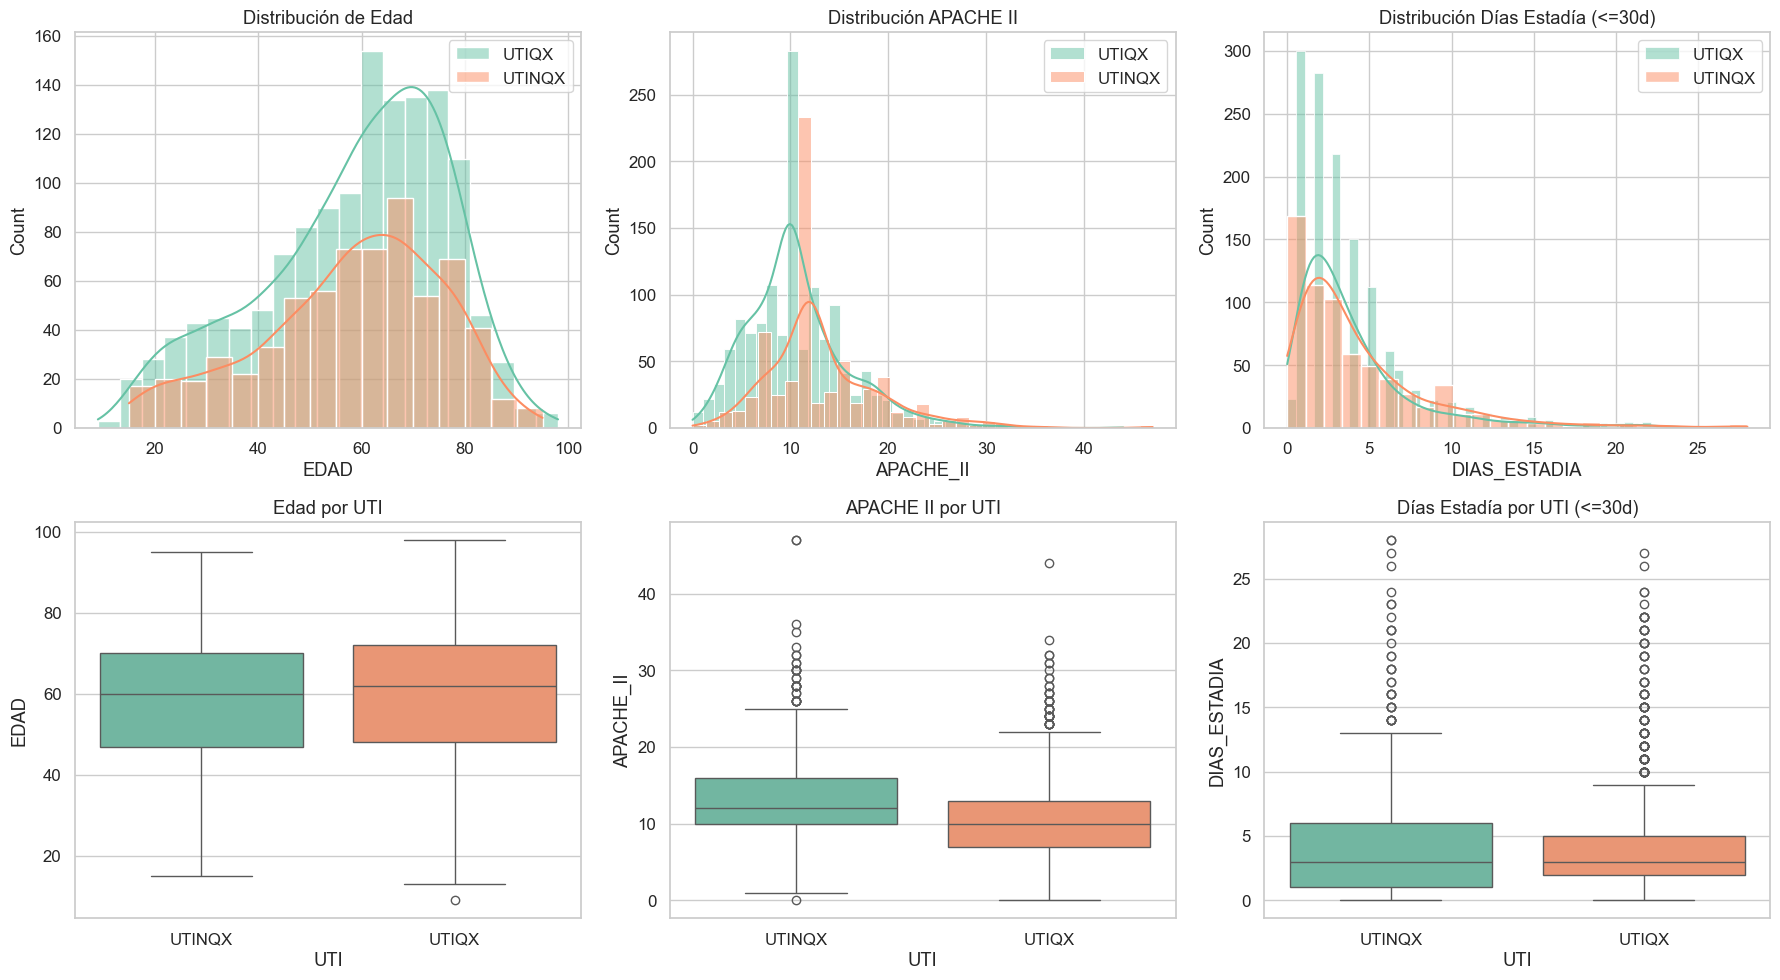

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Edad
for i, uti in enumerate(['UTIQX', 'UTINQX']):
    sub = df[df.UTI == uti]
    sns.histplot(sub.EDAD, kde=True, ax=axes[0, 0], label=uti, alpha=0.5)
axes[0, 0].set_title('Distribución de Edad')
axes[0, 0].legend()

# APACHE II
for uti in ['UTIQX', 'UTINQX']:
    sub = df[df.UTI == uti]
    sns.histplot(sub.APACHE_II, kde=True, ax=axes[0, 1], label=uti, alpha=0.5)
axes[0, 1].set_title('Distribución APACHE II')
axes[0, 1].legend()

# Días estadía
for uti in ['UTIQX', 'UTINQX']:
    sub = df[df.UTI == uti]
    sns.histplot(sub.DIAS_ESTADIA[sub.DIAS_ESTADIA <= 30], kde=True, ax=axes[0, 2], label=uti, alpha=0.5)
axes[0, 2].set_title('Distribución Días Estadía (<=30d)')
axes[0, 2].legend()

# Boxplots
sns.boxplot(data=df, x='UTI', y='EDAD', ax=axes[1, 0], palette='Set2')
axes[1, 0].set_title('Edad por UTI')

sns.boxplot(data=df, x='UTI', y='APACHE_II', ax=axes[1, 1], palette='Set2')
axes[1, 1].set_title('APACHE II por UTI')

sns.boxplot(data=df[df.DIAS_ESTADIA <= 30], x='UTI', y='DIAS_ESTADIA', ax=axes[1, 2], palette='Set2')
axes[1, 2].set_title('Días Estadía por UTI (<=30d)')

plt.tight_layout()
plt.savefig('eda_outputs/univariable_distribucion.png', dpi=150, bbox_inches='tight')
plt.show()

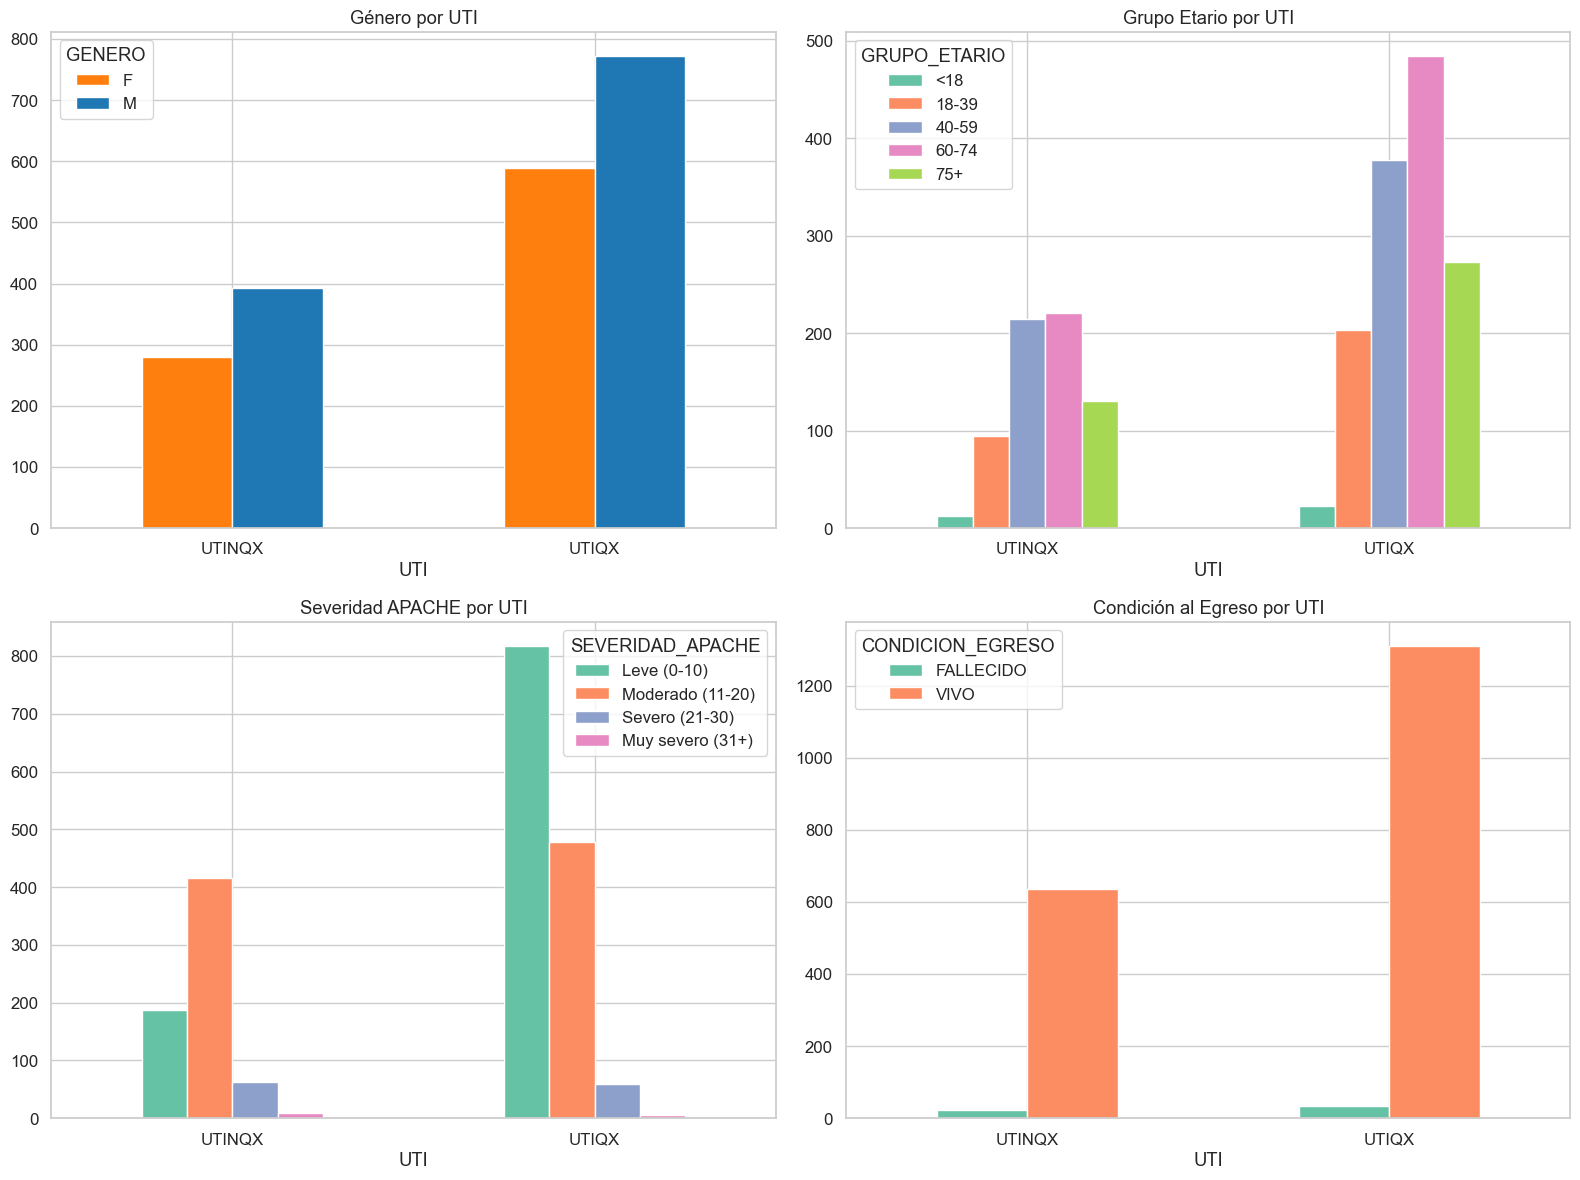

In [14]:
# Variables categóricas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Género
ct_gen = df.groupby(['UTI', 'GENERO']).size().unstack(fill_value=0)
ct_gen.plot(kind='bar', ax=axes[0, 0], color=['#ff7f0e', '#1f77b4'])
axes[0, 0].set_title('Género por UTI')
axes[0, 0].tick_params(axis='x', rotation=0)

# Grupo etario
ct_edad = df.groupby(['UTI', 'GRUPO_ETARIO']).size().unstack(fill_value=0)
ct_edad.plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Grupo Etario por UTI')
axes[0, 1].tick_params(axis='x', rotation=0)

# Severidad APACHE
ct_sev = df.groupby(['UTI', 'SEVERIDAD_APACHE']).size().unstack(fill_value=0)
ct_sev.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Severidad APACHE por UTI')
axes[1, 0].tick_params(axis='x', rotation=0)

# Condición al egreso
ct_egr = df.groupby(['UTI', 'CONDICION_EGRESO']).size().unstack(fill_value=0)
ct_egr.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Condición al Egreso por UTI')
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('eda_outputs/univariable_categoricas.png', dpi=150, bbox_inches='tight')
plt.show()

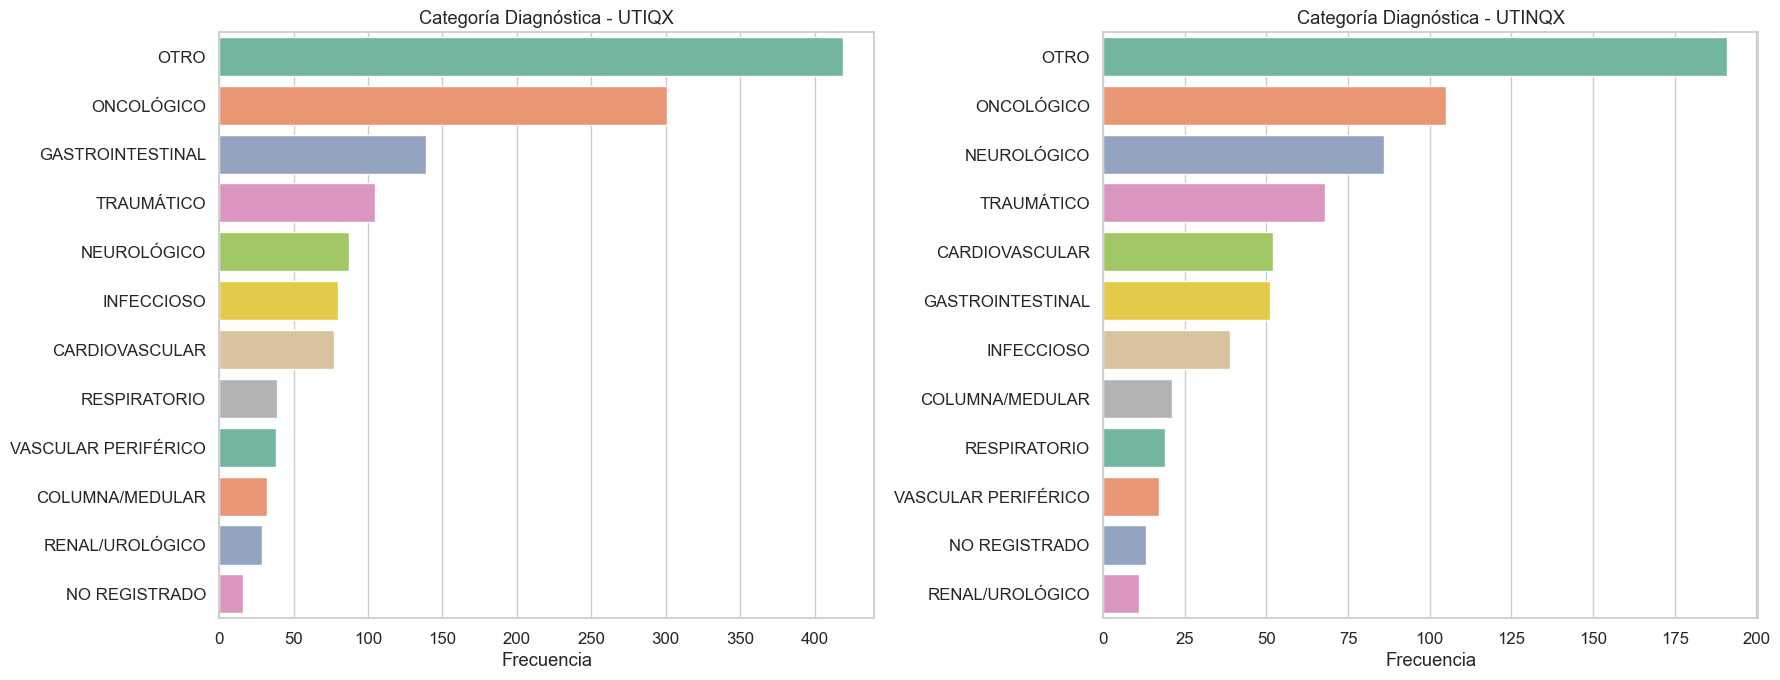

In [15]:
# Diagnósticos agrupados
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for i, uti in enumerate(['UTIQX', 'UTINQX']):
    sub = df[df.UTI == uti]
    order = sub.CATEGORIA_DX.value_counts().index
    sns.countplot(y='CATEGORIA_DX', data=sub, order=order, ax=axes[i], palette='Set2')
    axes[i].set_title(f'Categoría Diagnóstica - {uti}')
    axes[i].set_xlabel('Frecuencia')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.savefig('eda_outputs/diagnosticos_agrupados.png', dpi=150, bbox_inches='tight')
plt.show()

## 6 — Análisis bivariable y multivariable

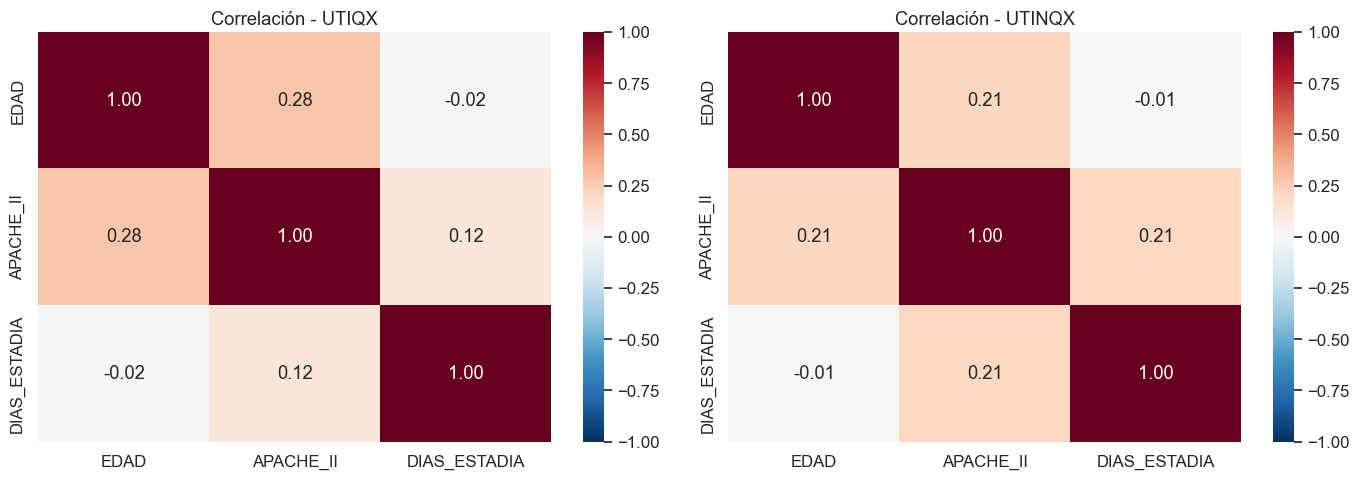

In [16]:
# 6.1 Matriz de correlación por UTI
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i, uti in enumerate(['UTIQX', 'UTINQX']):
    sub = df[df.UTI == uti][num_cols]
    corr = sub.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                vmin=-1, vmax=1, ax=axes[i])
    axes[i].set_title(f'Correlación - {uti}')

plt.tight_layout()
plt.savefig('eda_outputs/correlacion.png', dpi=150, bbox_inches='tight')
plt.show()

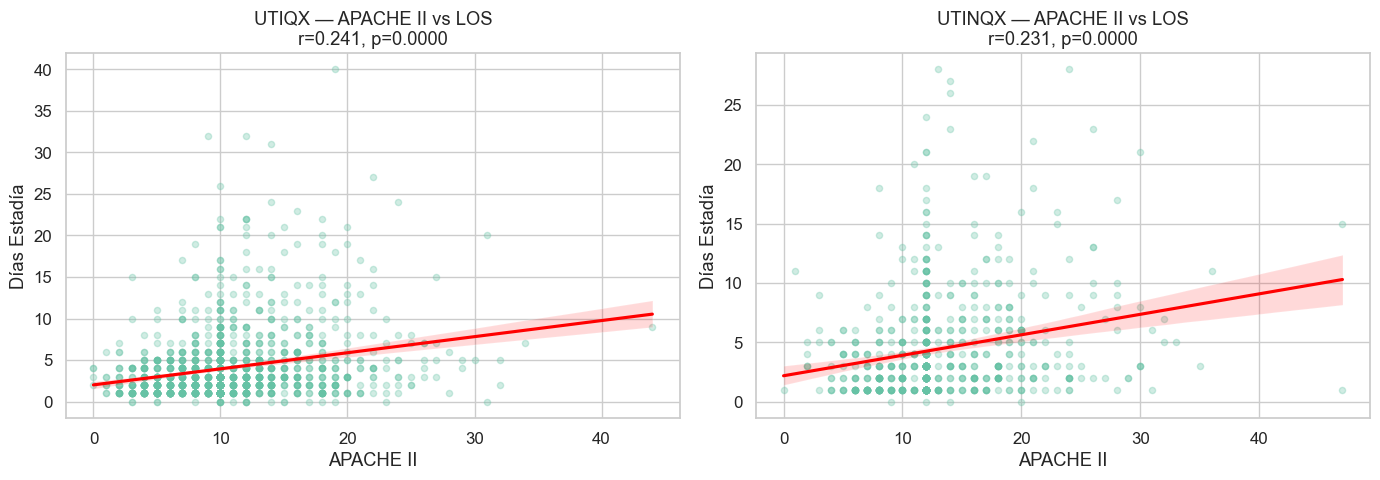

In [17]:
# 6.2 APACHE II vs Días Estadía (scatter + regresión)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i, uti in enumerate(['UTIQX', 'UTINQX']):
    sub = df[(df.UTI == uti) & (df.DIAS_ESTADIA <= 40)]
    sns.regplot(x='APACHE_II', y='DIAS_ESTADIA', data=sub, ax=axes[i],
                scatter_kws={'alpha': 0.3, 's': 20}, line_kws={'color': 'red'})
    r, p = stats.pearsonr(sub.APACHE_II.dropna(), sub.DIAS_ESTADIA.dropna())
    axes[i].set_title(f'{uti} — APACHE II vs LOS\nr={r:.3f}, p={p:.4f}')
    axes[i].set_xlabel('APACHE II')
    axes[i].set_ylabel('Días Estadía')

plt.tight_layout()
plt.savefig('eda_outputs/apache_vs_los.png', dpi=150, bbox_inches='tight')
plt.show()

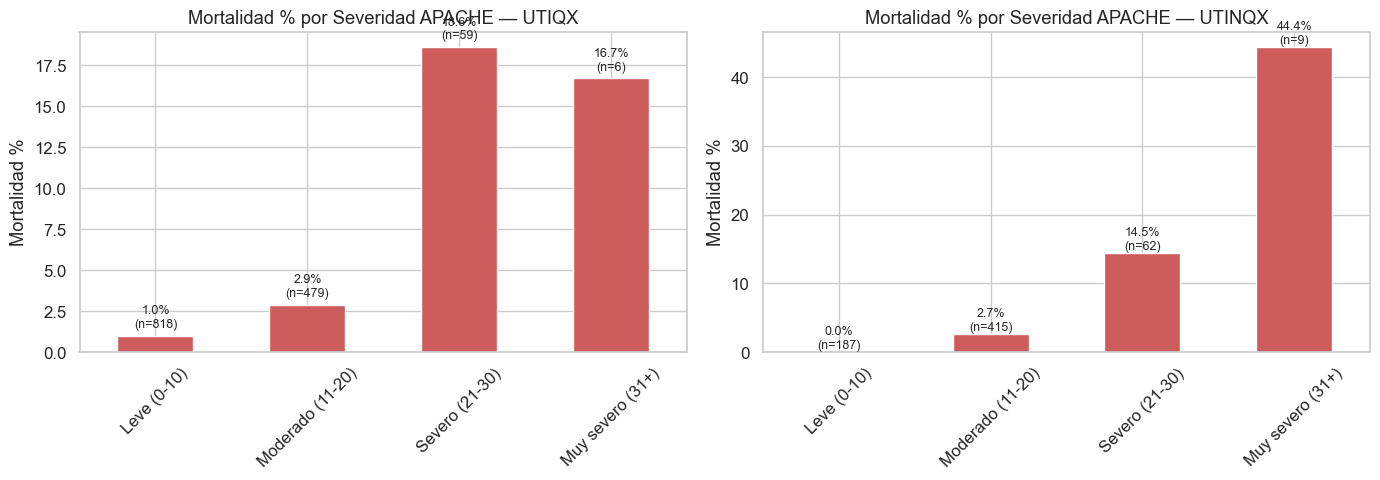

In [18]:
# 6.3 APACHE II vs Mortalidad
df['FALLECIDO'] = (df.CONDICION_EGRESO == 'FALLECIDO').astype(int)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i, uti in enumerate(['UTIQX', 'UTINQX']):
    sub = df[df.UTI == uti]
    mort_sev = sub.groupby('SEVERIDAD_APACHE')['FALLECIDO'].agg(['sum', 'count'])
    mort_sev['tasa'] = (mort_sev['sum'] / mort_sev['count'] * 100).round(1)
    mort_sev['tasa'].plot(kind='bar', ax=axes[i], color='indianred')
    axes[i].set_title(f'Mortalidad % por Severidad APACHE — {uti}')
    axes[i].set_ylabel('Mortalidad %')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)
    # Anotar valores
    for j, (idx, row) in enumerate(mort_sev.iterrows()):
        axes[i].text(j, row['tasa'] + 0.5, f"{row['tasa']}%\n(n={int(row['count'])})",
                     ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('eda_outputs/mortalidad_por_severidad.png', dpi=150, bbox_inches='tight')
plt.show()

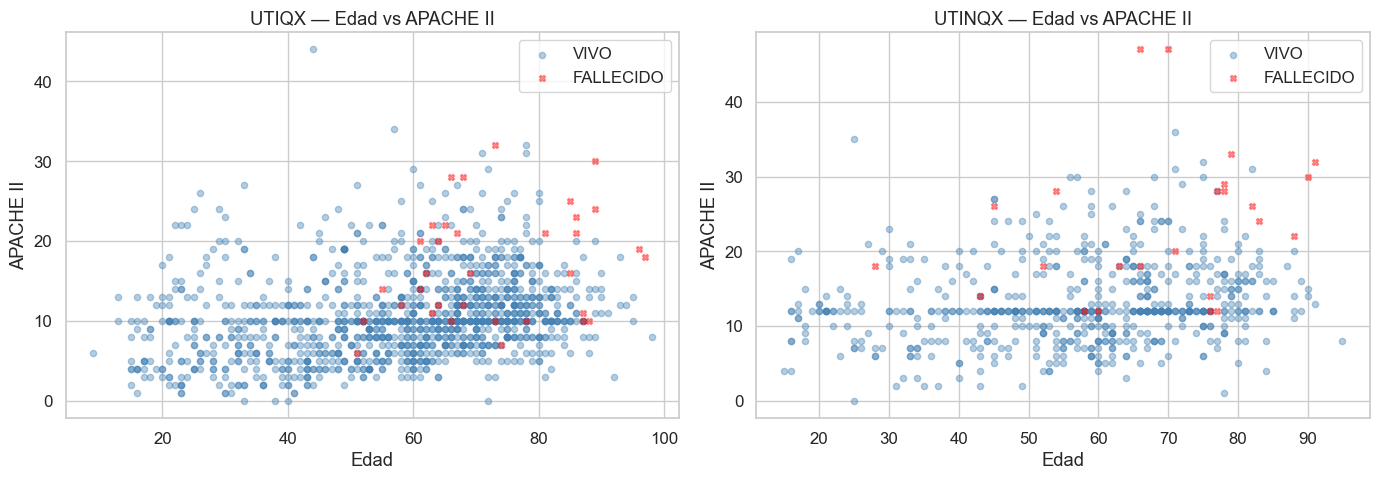

In [19]:
# 6.4 Edad vs APACHE II coloreado por condición de egreso
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i, uti in enumerate(['UTIQX', 'UTINQX']):
    sub = df[df.UTI == uti]
    for cond, color, marker in [('VIVO', 'steelblue', 'o'), ('FALLECIDO', 'red', 'X')]:
        s = sub[sub.CONDICION_EGRESO == cond]
        axes[i].scatter(s.EDAD, s.APACHE_II, c=color, marker=marker,
                       alpha=0.4, s=20, label=cond)
    axes[i].set_title(f'{uti} — Edad vs APACHE II')
    axes[i].set_xlabel('Edad')
    axes[i].set_ylabel('APACHE II')
    axes[i].legend()

plt.tight_layout()
plt.savefig('eda_outputs/edad_vs_apache_egreso.png', dpi=150, bbox_inches='tight')
plt.show()

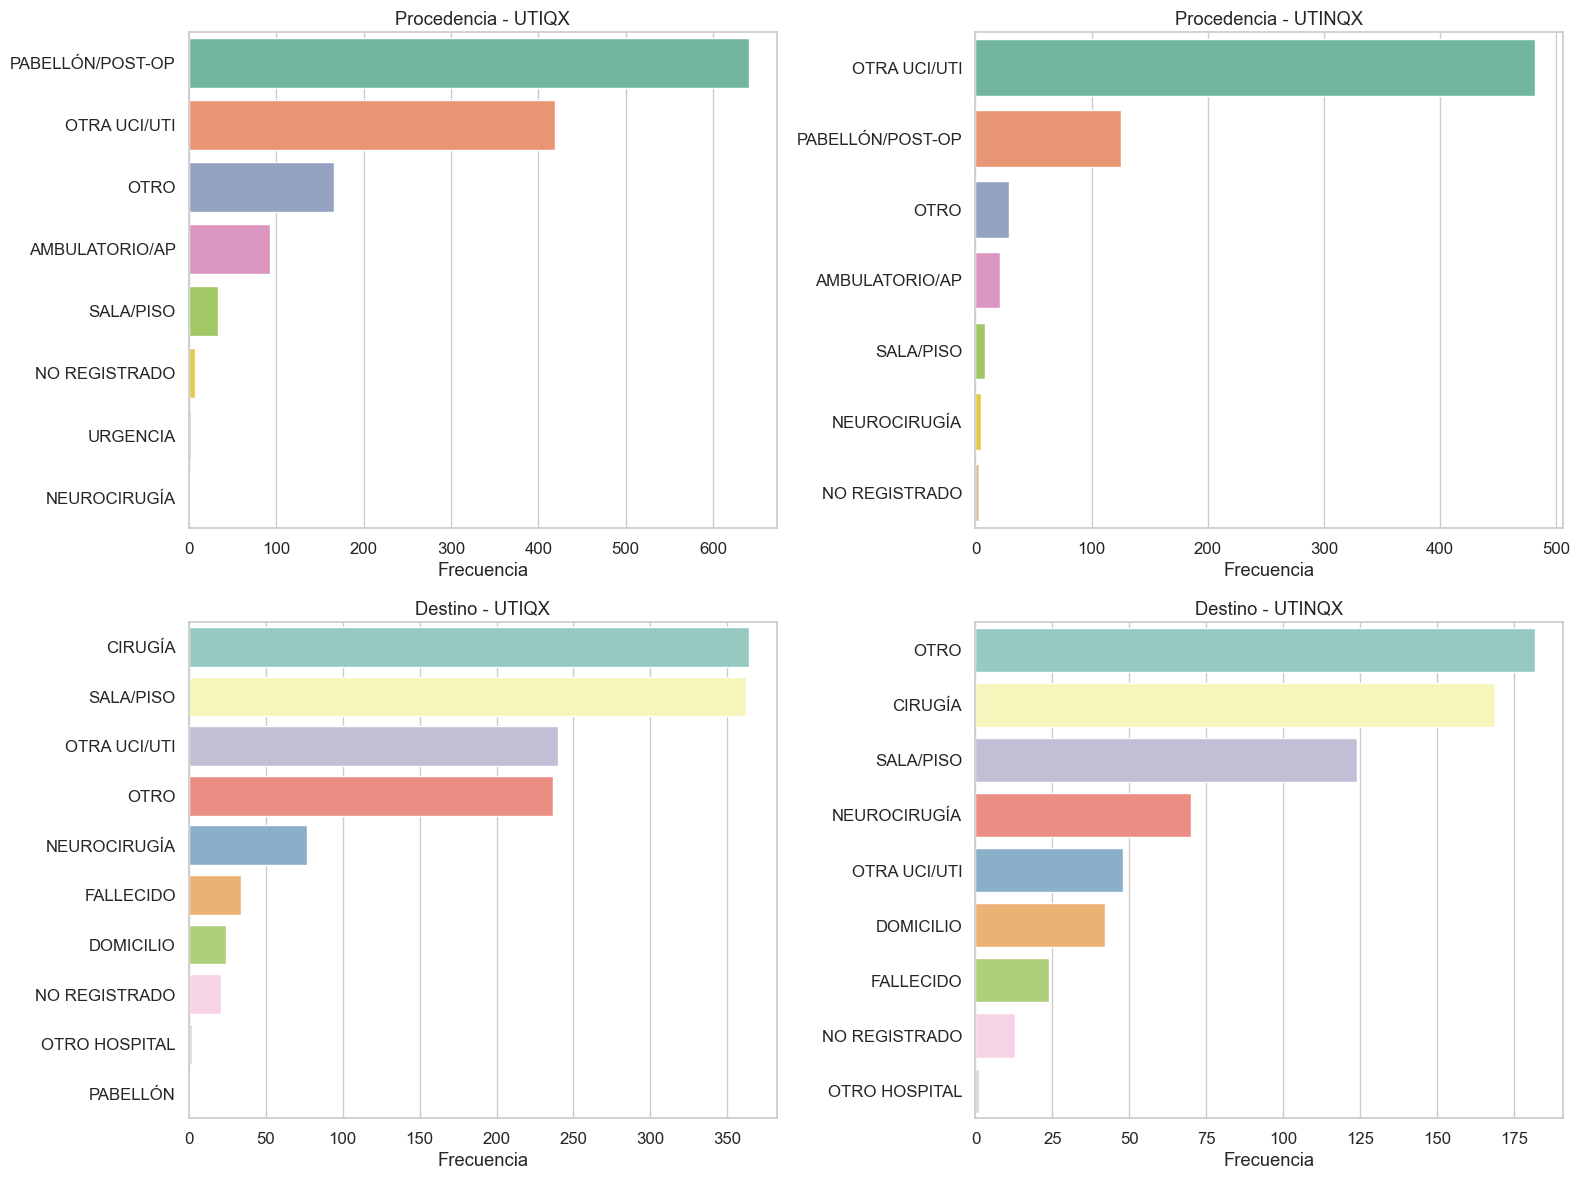

In [20]:
# 6.5 Flujo: Procedencia y Destino
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for i, uti in enumerate(['UTIQX', 'UTINQX']):
    sub = df[df.UTI == uti]
    # Procedencia
    order_p = sub.PROC_GRUPO.value_counts().index
    sns.countplot(y='PROC_GRUPO', data=sub, order=order_p, ax=axes[0, i], palette='Set2')
    axes[0, i].set_title(f'Procedencia - {uti}')
    axes[0, i].set_xlabel('Frecuencia')
    axes[0, i].set_ylabel('')
    
    # Destino
    order_d = sub.DEST_GRUPO.value_counts().index
    sns.countplot(y='DEST_GRUPO', data=sub, order=order_d, ax=axes[1, i], palette='Set3')
    axes[1, i].set_title(f'Destino - {uti}')
    axes[1, i].set_xlabel('Frecuencia')
    axes[1, i].set_ylabel('')

plt.tight_layout()
plt.savefig('eda_outputs/flujo_procedencia_destino.png', dpi=150, bbox_inches='tight')
plt.show()

## 7 — Detección y manejo de outliers

In [21]:
# Detección con IQR
def detect_outliers_iqr(series, factor=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - factor * IQR
    upper = Q3 + factor * IQR
    return (series < lower) | (series > upper), lower, upper

print('=== OUTLIERS (IQR x1.5) ===')
for col in num_cols:
    for uti in ['UTIQX', 'UTINQX']:
        sub = df[df.UTI == uti][col].dropna()
        outliers, lo, hi = detect_outliers_iqr(sub)
        n_out = outliers.sum()
        pct = (n_out / len(sub) * 100)
        print(f'{uti} - {col}: {n_out} outliers ({pct:.1f}%) | Rango [{lo:.1f}, {hi:.1f}]')

print('\n** Nota: En UCI los outliers son clínicamente significativos (pacientes graves).'
      ' Se conservan para el análisis pero se documentan. **')

=== OUTLIERS (IQR x1.5) ===
UTIQX - EDAD: 1 outliers (0.1%) | Rango [12.0, 108.0]
UTINQX - EDAD: 0 outliers (0.0%) | Rango [12.5, 104.5]
UTIQX - APACHE_II: 40 outliers (2.9%) | Rango [-2.0, 22.0]
UTINQX - APACHE_II: 31 outliers (4.6%) | Rango [1.0, 25.0]
UTIQX - DIAS_ESTADIA: 118 outliers (8.7%) | Rango [-2.5, 9.5]
UTINQX - DIAS_ESTADIA: 34 outliers (5.1%) | Rango [-6.5, 13.5]

** Nota: En UCI los outliers son clínicamente significativos (pacientes graves). Se conservan para el análisis pero se documentan. **


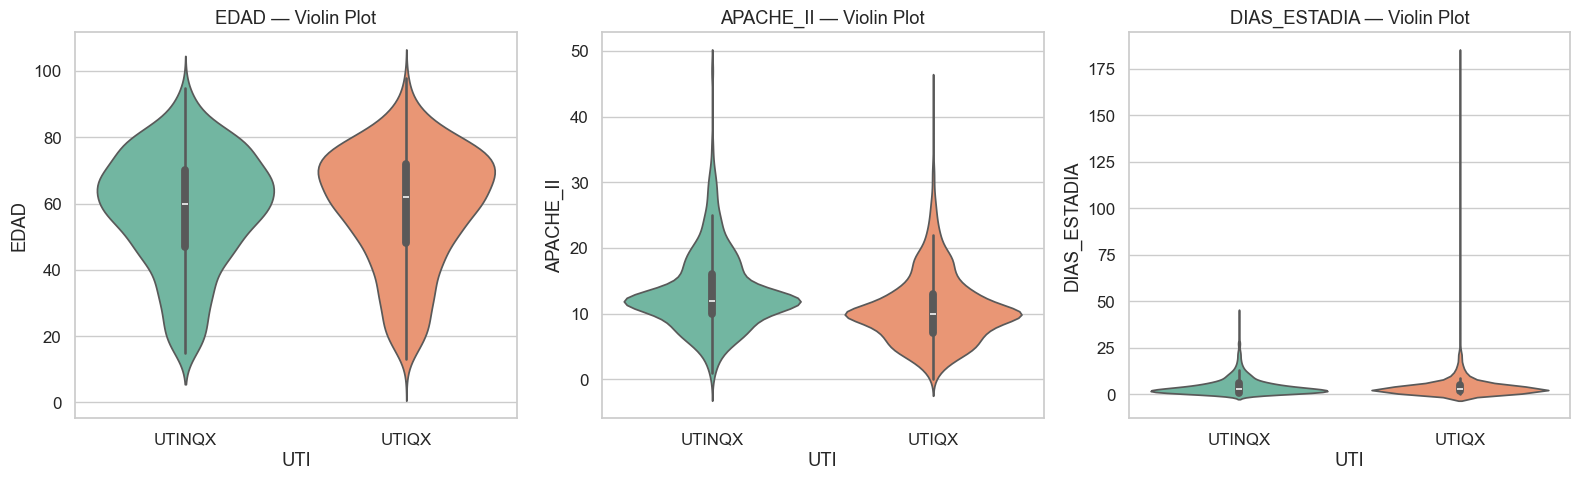

In [22]:
# Visualización de outliers con violin plots
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for i, col in enumerate(num_cols):
    sns.violinplot(data=df, x='UTI', y=col, ax=axes[i], palette='Set2', inner='box')
    axes[i].set_title(f'{col} — Violin Plot')

plt.tight_layout()
plt.savefig('eda_outputs/outliers_violin.png', dpi=150, bbox_inches='tight')
plt.show()

## 8 — Análisis temporal

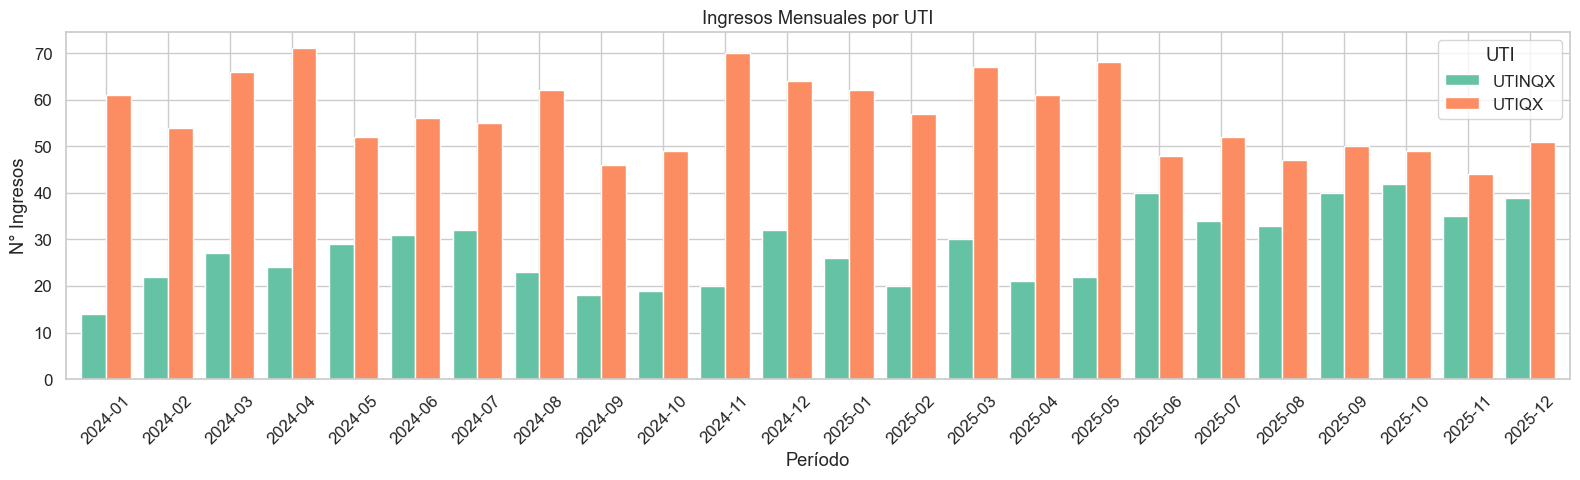

In [23]:
# Ingresos mensuales por UTI
df['ANIO_MES'] = df['INGRESO'].dt.to_period('M')
monthly = df.groupby(['ANIO_MES', 'UTI']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(16, 5))
monthly.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Ingresos Mensuales por UTI')
ax.set_xlabel('Período')
ax.set_ylabel('N° Ingresos')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig('eda_outputs/ingresos_mensuales.png', dpi=150, bbox_inches='tight')
plt.show()

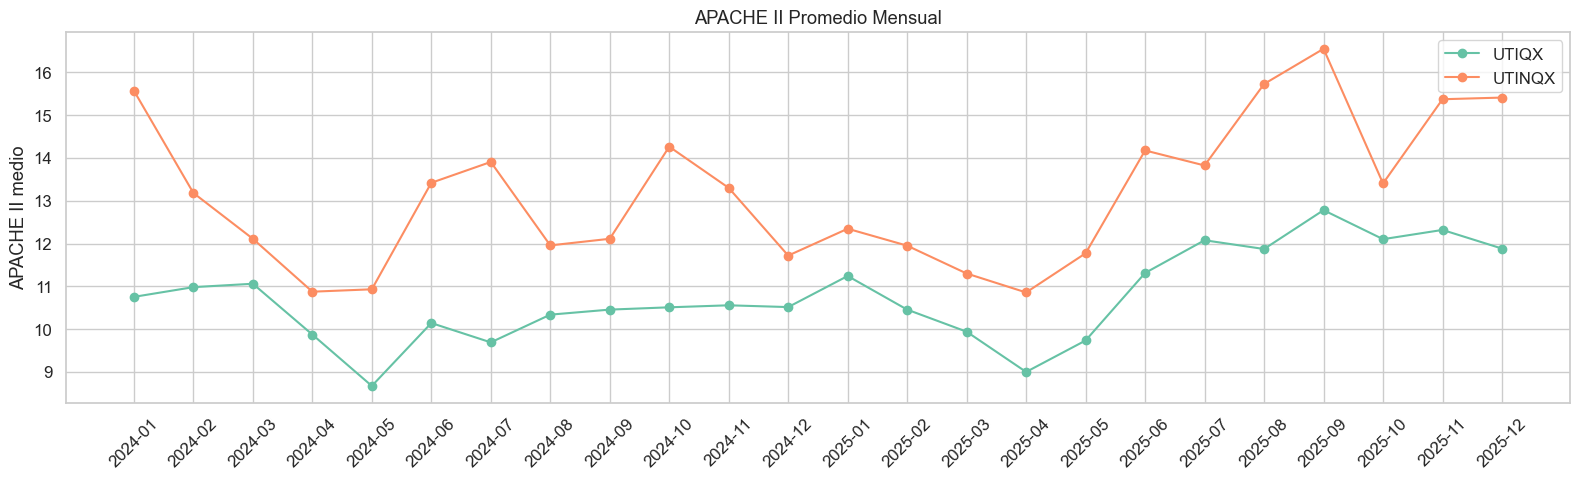

In [24]:
# Tendencia de APACHE II mensual
monthly_apache = df.groupby(['ANIO_MES', 'UTI'])['APACHE_II'].mean().unstack()

fig, ax = plt.subplots(figsize=(16, 5))
for uti in ['UTIQX', 'UTINQX']:
    vals = monthly_apache[uti]
    ax.plot(range(len(vals)), vals.values, marker='o', label=uti)
ax.set_xticks(range(len(monthly_apache.index)))
ax.set_xticklabels([str(x) for x in monthly_apache.index], rotation=45)
ax.set_title('APACHE II Promedio Mensual')
ax.set_ylabel('APACHE II medio')
ax.legend()
plt.tight_layout()
plt.savefig('eda_outputs/apache_mensual.png', dpi=150, bbox_inches='tight')
plt.show()

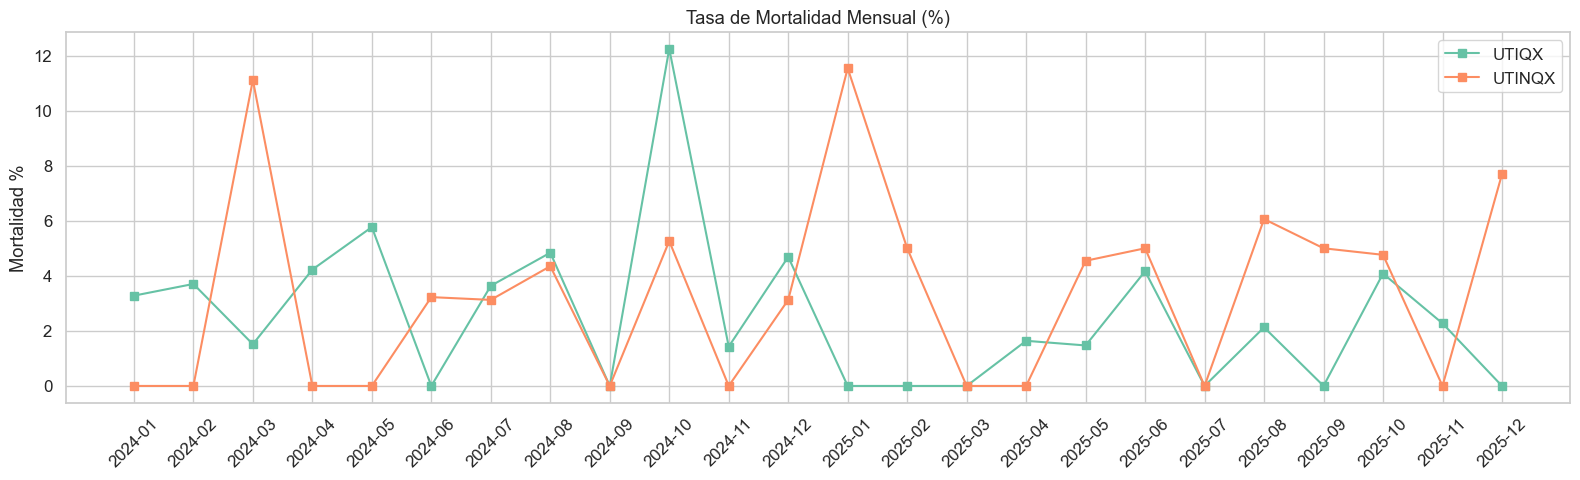

In [25]:
# Mortalidad mensual
monthly_mort = df.groupby(['ANIO_MES', 'UTI'])['FALLECIDO'].mean().unstack() * 100

fig, ax = plt.subplots(figsize=(16, 5))
for uti in ['UTIQX', 'UTINQX']:
    vals = monthly_mort[uti]
    ax.plot(range(len(vals)), vals.values, marker='s', label=uti)
ax.set_xticks(range(len(monthly_mort.index)))
ax.set_xticklabels([str(x) for x in monthly_mort.index], rotation=45)
ax.set_title('Tasa de Mortalidad Mensual (%)')
ax.set_ylabel('Mortalidad %')
ax.legend()
plt.tight_layout()
plt.savefig('eda_outputs/mortalidad_mensual.png', dpi=150, bbox_inches='tight')
plt.show()

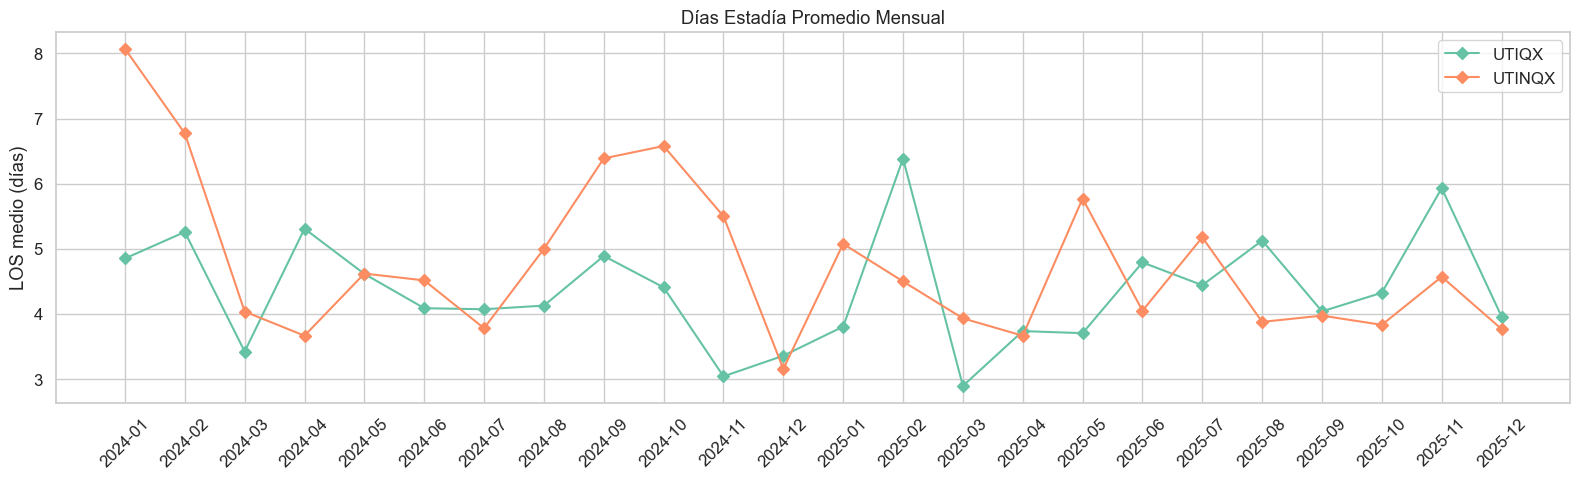

In [26]:
# LOS promedio mensual
monthly_los = df.groupby(['ANIO_MES', 'UTI'])['DIAS_ESTADIA'].mean().unstack()

fig, ax = plt.subplots(figsize=(16, 5))
for uti in ['UTIQX', 'UTINQX']:
    vals = monthly_los[uti]
    ax.plot(range(len(vals)), vals.values, marker='D', label=uti)
ax.set_xticks(range(len(monthly_los.index)))
ax.set_xticklabels([str(x) for x in monthly_los.index], rotation=45)
ax.set_title('Días Estadía Promedio Mensual')
ax.set_ylabel('LOS medio (días)')
ax.legend()
plt.tight_layout()
plt.savefig('eda_outputs/los_mensual.png', dpi=150, bbox_inches='tight')
plt.show()

## 9 — Tests estadísticos (UTIQX vs UTINQX)

In [27]:
from scipy.stats import mannwhitneyu, chi2_contingency

qx = df[df.UTI == 'UTIQX']
nqx = df[df.UTI == 'UTINQX']

print('=== Mann-Whitney U (variables numéricas) ===')
for col in num_cols:
    stat, p = mannwhitneyu(qx[col].dropna(), nqx[col].dropna(), alternative='two-sided')
    sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
    print(f'{col}: U={stat:.0f}, p={p:.6f} {sig}')

print('\n=== Chi-cuadrado (variables categóricas) ===')
for col in ['GENERO', 'CONDICION_EGRESO', 'SEVERIDAD_APACHE', 'GRUPO_ETARIO', 'CATEGORIA_DX']:
    ct = pd.crosstab(df['UTI'], df[col])
    chi2, p, dof, _ = chi2_contingency(ct)
    sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
    print(f'{col}: chi2={chi2:.2f}, p={p:.6f}, dof={dof} {sig}')

=== Mann-Whitney U (variables numéricas) ===
EDAD: U=472068, p=0.269984 ns
APACHE_II: U=322482, p=0.000000 ***
DIAS_ESTADIA: U=439080, p=0.118323 ns

=== Chi-cuadrado (variables categóricas) ===
GENERO: chi2=0.43, p=0.511673, dof=1 ns
CONDICION_EGRESO: chi2=1.58, p=0.209230, dof=1 ns
SEVERIDAD_APACHE: chi2=189.93, p=0.000000, dof=3 ***
GRUPO_ETARIO: chi2=4.05, p=0.399269, dof=4 ns
CATEGORIA_DX: chi2=44.97, p=0.000005, dof=11 ***


## 10 — Conclusiones y hallazgos clave

In [28]:
# Generar resumen automático
print('='*60)
print('RESUMEN EDA — ESTADÍSTICA UTI 2024-2025')
print('='*60)

for uti in ['UTIQX', 'UTINQX']:
    sub = df[df.UTI == uti]
    print(f'\n--- {uti} ---')
    print(f'  Registros: {len(sub)}')
    print(f'  Período: {sub.INGRESO.min().date()} a {sub.INGRESO.max().date()}')
    print(f'  Edad: {sub.EDAD.mean():.1f} ± {sub.EDAD.std():.1f} años (mediana {sub.EDAD.median():.0f})')
    print(f'  Género: {(sub.GENERO=="M").mean()*100:.1f}% masculino')
    print(f'  APACHE II: {sub.APACHE_II.mean():.1f} ± {sub.APACHE_II.std():.1f} (mediana {sub.APACHE_II.median():.0f})')
    print(f'  LOS: {sub.DIAS_ESTADIA.mean():.1f} ± {sub.DIAS_ESTADIA.std():.1f} días (mediana {sub.DIAS_ESTADIA.median():.0f})')
    print(f'  Mortalidad: {(sub.CONDICION_EGRESO=="FALLECIDO").mean()*100:.2f}%')
    print(f'  Top diagnóstico: {sub.CATEGORIA_DX.value_counts().index[0]} ({sub.CATEGORIA_DX.value_counts().iloc[0]})')

print('\n' + '='*60)
print('DIFERENCIAS CLAVE:')
print('- UTINQX presenta mayor severidad (APACHE II más alto)')
print('- Perfil diagnóstico diferenciado entre ambas unidades')
print('- Tests estadísticos confirman diferencias significativas')
print('='*60)

RESUMEN EDA — ESTADÍSTICA UTI 2024-2025

--- UTIQX ---
  Registros: 1362
  Período: 2024-01-02 a 2025-12-31
  Edad: 58.7 ± 17.9 años (mediana 62)
  Género: 56.8% masculino
  APACHE II: 10.7 ± 5.2 (mediana 10)
  LOS: 4.3 ± 7.1 días (mediana 3)
  Mortalidad: 2.50%
  Top diagnóstico: OTRO (419)

--- UTINQX ---
  Registros: 673
  Período: 2024-01-03 a 2025-12-31
  Edad: 58.1 ± 17.5 años (mediana 60)
  Género: 58.4% masculino
  APACHE II: 13.4 ± 5.9 (mediana 12)
  LOS: 4.5 ± 4.7 días (mediana 3)
  Mortalidad: 3.57%
  Top diagnóstico: OTRO (191)

DIFERENCIAS CLAVE:
- UTINQX presenta mayor severidad (APACHE II más alto)
- Perfil diagnóstico diferenciado entre ambas unidades
- Tests estadísticos confirman diferencias significativas


## 11 — Exportar datos limpios y resumen

In [29]:
# Guardar dataset limpio (anonimizado)
export_cols = ['EDAD', 'GENERO', 'INGRESO', 'EGRESO', 'DIAS_ESTADIA', 'APACHE_II',
               'CONDICION_EGRESO', 'PROCEDENCIA', 'DESTINO', 'UTI',
               'GRUPO_ETARIO', 'SEVERIDAD_APACHE', 'CAT_ESTADIA', 'CATEGORIA_DX',
               'PROC_GRUPO', 'DEST_GRUPO', 'ANIO', 'MES', 'FALLECIDO']
df[export_cols].to_csv('eda_outputs/dataset_limpio_anonimizado.csv', index=False)

# Guardar resumen comparativo
df_resumen.T.to_csv('eda_outputs/resumen_comparativo.csv')

print('Archivos exportados a eda_outputs/')
print('  - dataset_limpio_anonimizado.csv')
print('  - resumen_comparativo.csv')

Archivos exportados a eda_outputs/
  - dataset_limpio_anonimizado.csv
  - resumen_comparativo.csv


---
**Fin del EDA** — Los hallazgos se consolidan en el dashboard HTML generado por el script complementario.